In [1]:
import argparse
import json
import tensorflow as tf
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
import matplotlib.path as mplPath

from fr3D.train.utils import setup_datasets
from fr3D.data.utils import get_normalization
from fr3D.models import ConvAutoencoder, ConvAutoencoderCGAN, ConvAutoencoderC

tf.keras.backend.set_image_data_format('channels_last')

def check_in_polygon(pts, vertices):
    path = mplPath.Path(vertices)
    return path.contains_points(pts)

def mape_with_threshold(yp, yt, pcterror_threshold=np.inf, max_magnitude_threshold=0.0, eps=1e-7):
    pct_errors = 100*tf.abs((yp-yt)/(eps + yt))
    pcterror_mask = pct_errors < pcterror_threshold
    max_magnitude_mask = tf.logical_not(tf.abs(yt) < (max_magnitude_threshold*tf.reduce_max(tf.abs(yt))))
    filtering_indices = tf.where(tf.logical_and(pcterror_mask, max_magnitude_mask))
    filtered_pcterrors = tf.gather_nd(pct_errors, filtering_indices)
    return float(tf.reduce_mean(filtered_pcterrors))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = 1

In [2]:
Re = 500
expt_variable = 'U'

#dataset_path = f'/fr3D/postprocessed/annulus_64_{Re}.h5'
dataset_path = f'/fr3D/postprocessed/annulus_64.h5'
#dataset_path = f'/fr3D/postprocessed/annulus_64_plane.h5'

#CGAN
#experiment_config = f'/fr3D/configs/training/ConvAutoencoderCGAN_{expt_variable}.json'
#weights_path = f'/storage/weights/ConvAutoencoderCGAN_{expt_variable}_Annulus64/ConvAutoencoderCGAN_{expt_variable}_Annulus64.h5'

#ConvAutoencoderC
experiment_config = f'/fr3D/configs/training/ConvAutoencoderC_{expt_variable}.json'
weights_path = f'/storage/weights{Re}/ConvAutoencoderC_{expt_variable}_Annulus64/ConvAutoencoderC_{expt_variable}_Annulus64.h5'



datasetf = h5py.File(dataset_path,'r')

shuf_buf = 1
config = json.load(open(experiment_config,'r'))
train_dataset, test_dataset = setup_datasets(config, dataset_path, shuf_buf, case_names=True, evaluation=True)
sensor_shape = train_dataset.element_spec[0][0].shape
full_field_shape = train_dataset.element_spec[0][1].shape

def get_normalization_type(node_configs):
    normalization_spec = {'method': None}
    for node in node_configs:
        if node['nodetype'] == 'normalize':
            normalization_spec = node['normalization_spec']
            break
    normalizer = get_normalization(**normalization_spec, batch_mode=True)
    return normalizer
normalizer = get_normalization_type(config['dataset']['node_configurations'])

Training geometries: ('shape_69', 'shape_33', 'shape_37', 'shape_374', 'shape_239', 'shape_224', 'shape_160', 'shape_237', 'shape_135', 'cylinder', 'shape_152', 'shape_186', 'shape_92', 'shape_21', 'shape_58', 'shape_110', 'shape_88', 'shape_59', 'shape_14', 'shape_197', 'shape_55', 'shape_8', 'shape_170', 'shape_234', 'shape_43', 'shape_149', 'shape_228', 'shape_48', 'shape_130', 'shape_90', 'shape_137', 'shape_84', 'shape_361', 'shape_182', 'shape_68', 'shape_113', 'shape_244', 'shape_327', 'shape_216', 'shape_15', 'shape_63', 'shape_213', 'shape_126', 'shape_236', 'shape_50', 'shape_18', 'shape_157', 'shape_89', 'shape_17', 'shape_355', 'shape_29', 'shape_146', 'shape_164', 'shape_11', 'shape_150', 'shape_220', 'shape_13', 'shape_60', 'shape_12', 'shape_369', 'shape_218', 'shape_78', 'shape_331', 'shape_97', 'shape_329', 'shape_31', 'shape_39', 'shape_241', 'shape_41', 'shape_346', 'shape_94', 'shape_61', 'shape_23', 'shape_339', 'shape_255', 'shape_83', 'shape_338', 'shape_54', 'sh

2022-12-09 22:58:50.288619: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-12-09 22:58:50.288801: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-12-09 22:58:50.487508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 22:58:51.416633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38262 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-09 22:58:51.418086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] 

In [ ]:
generator = ConvAutoencoder(input_shape=full_field_shape[1:], **config['generator'])
model = ConvAutoencoderCGAN(sensor_shape[1],generator,**config.get('discriminator',{}))
model.compile(d_optimizer = tf.keras.optimizers.get(config['training']['d_optimizer']),
            g_optimizer = tf.keras.optimizers.get(config['training']['g_optimizer']),
            l_optimizer = tf.keras.optimizers.get(config['training']['l_optimizer']),
            global_batch_size=config['dataset']['batch_size'])
_ = model(next(iter(test_dataset))[0][0], autoencode=False)

model.load_weights(weights_path)


In [3]:
model = ConvAutoencoderC(dense_input_units=sensor_shape[1],
                         autoencoder_input_shape=full_field_shape[1:],
                         **config['model'])
loss_fn = "mse"#tf.keras.losses.get(config['training']['loss'])
model.compile(l_optimizer= tf.keras.optimizers.get(config['training']['l_optimizer']),
              loss=loss_fn,
              optimizer = tf.keras.optimizers.get(config['training']['ae_optimizer']),
              metrics = config['training'].get('metrics', None))
model.load_weights(weights_path)

In [4]:
ds = iter(test_dataset)

2022-12-09 22:59:07.473931: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-09 22:59:07.839866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-09 22:59:08.260099: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


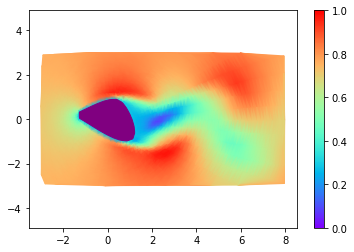

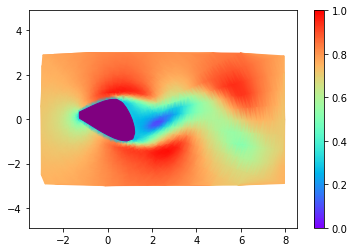

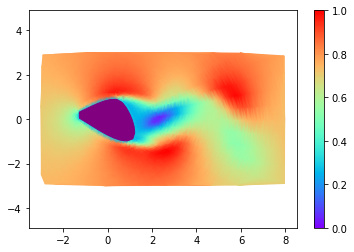

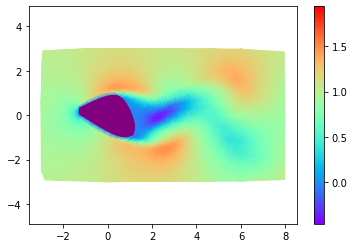

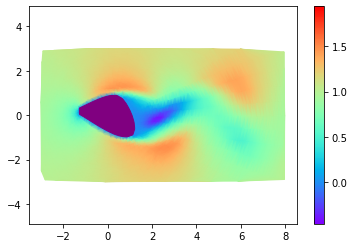

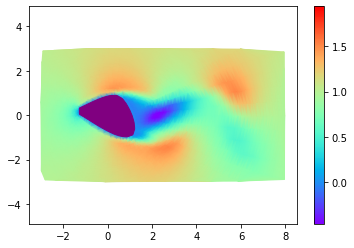

==Slice % err==
3.8549046516418457
3.133538246154785
==Whole snapshot % err==
2.131920576095581
1.466116189956665
==Slice % err unnormalized==
8.934944152832031
8.359663009643555
==Whole snapshot % err unnormalized==
4.3841071128845215
3.2287380695343018


In [5]:
get_new=True
if get_new:
    (inp, target, norm_params), case_names = next(ds)
    pred = model(inp,autoencode=False)
    ae_pred = model(target,autoencode=True)

    targetn = normalizer.undo(target, norm_params[:,0,:])
    predn = normalizer.undo(pred, norm_params[:,0,:])
    ae_predn = normalizer.undo(ae_pred, norm_params[:,0,:])

idx=13
zsl=48

vmax = 1.0
vmin = 0.0

stdf = 10.0
meann = tf.reduce_mean(target[idx,:,:,zsl])
stdn = tf.math.reduce_std(target[idx,:,:,zsl])
vmaxn = meann+stdf*stdn
vminn = meann-stdf*stdn


coords = datasetf[case_names[idx].numpy()]['full_field_coords']
x = np.reshape(coords[:,:,zsl,0],[-1])
y = np.reshape(coords[:,:,zsl,1],[-1])

p = np.reshape(pred[idx,:,:,zsl,0], [-1])
pn = np.reshape(predn[idx,:,:,zsl,0], [-1])
ap = np.reshape(ae_pred[idx,:,:,zsl,0], [-1])
apn = np.reshape(ae_predn[idx,:,:,zsl,0], [-1])
t = np.reshape(target[idx,:,:,zsl,0], [-1])
tn = np.reshape(targetn[idx,:,:,zsl,0], [-1])

outer_polygon = [(-3,3), (-3,-3), (8,-3), (8,3)]
spatialmask = check_in_polygon(np.stack([x,y],-1), outer_polygon)
spatialmasked_indices = np.where(spatialmask)[0]
x = x[spatialmasked_indices]
y = y[spatialmasked_indices]
p = p[spatialmasked_indices]
pn = pn[spatialmasked_indices]
ap = ap[spatialmasked_indices]
apn = apn[spatialmasked_indices]
t = t[spatialmasked_indices]
tn = tn[spatialmasked_indices]

polygon_vertices = datasetf[case_names[idx].numpy()]['full_field_coords'][0,:,zsl]

#Normalized plots
plt.figure()
plt.tripcolor(x,y,p, shading='gouraud', cmap='rainbow', vmax = vmax, vmin = vmin)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,ap, shading='gouraud', cmap='rainbow', vmax = vmax, vmin = vmin)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,t, shading='gouraud', cmap='rainbow', vmax = vmax, vmin = vmin)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

#Unnormalized plots
plt.figure()
plt.tripcolor(x,y,pn, shading='gouraud', cmap='rainbow', vmax = vmaxn, vmin = vminn)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,apn, shading='gouraud', cmap='rainbow', vmax = vmaxn, vmin = vminn)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

plt.figure()
plt.tripcolor(x,y,tn, shading='gouraud', cmap='rainbow', vmax = vmaxn, vmin = vminn)
plt.fill(polygon_vertices[...,0], polygon_vertices[...,1], color='purple')
plt.colorbar()
plt.axis('equal')
plt.show()
plt.close()

print("==Slice % err==")
print(mape_with_threshold(p,t,pcterror_threshold=200))
print(mape_with_threshold(ap,t,pcterror_threshold=200))
print("==Whole snapshot % err==")
print(mape_with_threshold(pred[idx],target[idx],pcterror_threshold=200))
print(mape_with_threshold(ae_pred[idx],target[idx],pcterror_threshold=200))
print("==Slice % err unnormalized==")
print(mape_with_threshold(pn,tn,pcterror_threshold=200))
print(mape_with_threshold(apn,tn,pcterror_threshold=200))
print("==Whole snapshot % err unnormalized==")
print(mape_with_threshold(predn[idx],targetn[idx],pcterror_threshold=200))
print(mape_with_threshold(ae_predn[idx],targetn[idx],pcterror_threshold=200))

In [62]:
from evtk import hl

def export_vtk(c, **fields):
    x = c[...,0].reshape(-1)
    y = c[...,1].reshape(-1)
    z = c[...,2].reshape(-1)
    data = {}
    for f in fields:
        data[f] = fields[f].reshape(-1).copy()
    hl.pointsToVTK("/storage/pressure3d", x, y, z, data = data)
    
export_vtk(coords, pred=predn[0,...,0], ae_pred=ae_predn[0,...,0].numpy(), gt = targetn[0,...,0].numpy())

0.387599
